# import Libraries and set settings 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
import statsmodels.stats.api as sms
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, \
    pearsonr, spearmanr, kendalltau, f_oneway, kruskal, normaltest
from statsmodels.stats.proportion import proportions_ztest

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
def data_info(data):
  print(50*' ',20*'^','About The Data','^'*20,2*"\n")
  print(2*"\n","Data Info:",2*"\n")
  print(data.info())
  print(f'\n \nNull Conut:\n{data.isnull().sum()} \n\n ')
  uniques=[]
  for i in data.columns:
    if  data[i].nunique()<10:
      uniques.append(i)
  print(f'\n \nNumber of unique columns ={len(uniques)}\n Names: {uniques}')
  for i in data.columns:
    if  data[i].nunique()<10:
      print(f'\n \nNumber Of Unique Cols In {i} = {data[i].nunique()}\n Values Are: \n{data[i].unique()}')
    elif data[i].nunique()<10:
      return 'No unique values'
  print(50*' ',20*'^','Data Statstics',20*'^',2*'\n')
  for i in data.columns:
    print(f'\nStatstics for {i} is: \n{data[i].describe()} \n \n')

In [4]:
df=pd.read_csv('E:\\py\Data\\A-B testing\\AB_Test_Results.csv')
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.00000
1,2423,control,0.00000
2,9411,control,0.00000
3,7311,control,0.00000
4,6174,variant,0.00000


In [5]:
df.tail()

,USER_ID,VARIANT_NAME,REVENUE
9995,1981,control,0.00000
9996,502,variant,0.00000
9997,9214,variant,0.00000
9998,7741,control,0.00000
9999,9468,control,0.00000


In [6]:
data_info(df)

                                                   ^^^^^^^^^^^^^^^^^^^^ About The Data ^^^^^^^^^^^^^^^^^^^^ 




 Data Info: 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB
None

 
Null Conut:
USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64 

 

 
Number of unique columns =1
 Names: ['VARIANT_NAME']

 
Number Of Unique Cols In VARIANT_NAME = 2
 Values Are: 
['variant' 'control']
                                                   ^^^^^^^^^^^^^^^^^^^^ Data Statstics ^^^^^^^^^^^^^^^^^^^^ 



Statstics for USER_ID is: 
count   10000.00000
mean     4981.08020
std      2890.59011
min         2.00000
25%      2468.75000
50%      4962.00000

In [7]:
df['USER_ID'].duplicated().sum()

3676

USER_ID may contanis duplicates in the VARIANT_NAME and that will effect the acuracy of the test 
<br>
so we have to make sure that all users are form the same gruop

In [8]:
# remove USER_ID who are in two different VARIANT 

duplicates = (df.groupby("USER_ID")["VARIANT_NAME"].nunique() == True)
duplicates = duplicates[duplicates]

# USER_ID_nunique data

df = df[df["USER_ID"].isin(duplicates.index)]

All users know are in one group

In [9]:
df.sort_values(by='REVENUE',ascending=False).head(10)

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01000
8168,2166,control,29.32000
2482,7356,variant,23.04000
6412,1053,control,20.07000
5217,3684,variant,19.47000
5530,282,control,18.56000
758,4445,control,17.05000
4031,2059,control,14.24000
9019,1973,control,14.07000
4561,4966,variant,12.99000


A/B groups stats

In [10]:
df.groupby(by='VARIANT_NAME').agg({'USER_ID': 'nunique',
                                               'REVENUE': ['sum', 'mean', 'median', 'count']})

USER_ID   REVENUE                      
             nunique       sum    mean  median count
VARIANT_NAME                                        
control         2390 470.56000 0.15551 0.00000  3026
variant         2393 179.32000 0.05891 0.00000  3044

In [11]:
# A/B Groups & Target Summary Stats
df.groupby("USER_ID")['REVENUE'].agg(["count", "median", "mean", "std", "max", 'sum']).sort_values(by='sum', ascending=False)

,count,median,mean,std,max,sum
USER_ID,,,,,,
3342,1,196.01000,196.01000,NaN,196.01000,196.01000
2166,2,14.66000,14.66000,20.73237,29.32000,29.32000
7356,1,23.04000,23.04000,NaN,23.04000,23.04000
1053,4,0.00000,5.01750,10.03500,20.07000,20.07000
3684,1,19.47000,19.47000,NaN,19.47000,19.47000
...,...,...,...,...,...,...
3363,1,0.00000,0.00000,NaN,0.00000,0.00000
3362,1,0.00000,0.00000,NaN,0.00000,0.00000
3361,1,0.00000,0.00000,NaN,0.00000,0.00000


In [12]:
print(f'Lower bound is :{sms.DescrStatsW(df["REVENUE"]).tconfint_mean(alpha=.05)[0]}\nUpper bound is : {sms.DescrStatsW(df["REVENUE"]).tconfint_mean(alpha=.03)[1]}')

Lower bound is :0.039794372950474055
Upper bound is : 0.18154874841311563


Text(0.5, 1.0, 'Revnue Per Group')

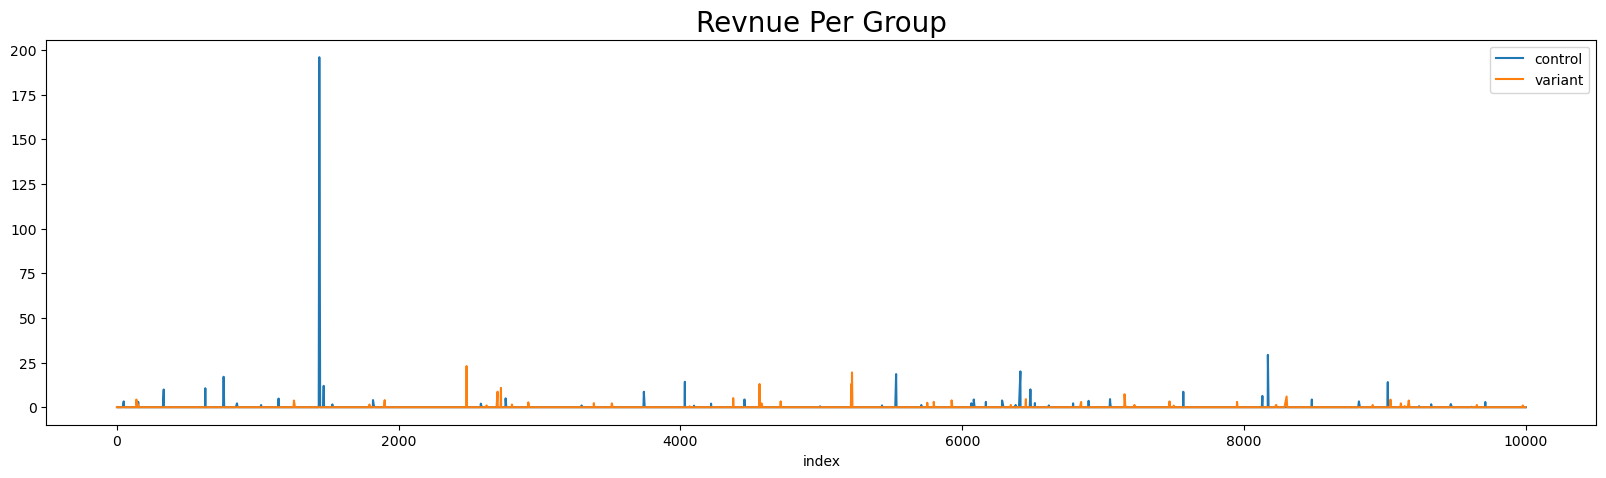

In [13]:
df[df['VARIANT_NAME'] == "control"].reset_index().set_index("index")['REVENUE'].plot(legend = True, label = "control", figsize = (20,5))
df[df['VARIANT_NAME'] == "variant"].reset_index().set_index("index")['REVENUE'].plot(legend = True, label = "variant")
plt.title('revnue per group'.title(),fontsize = 20)

The data sames to contains alot of outliers 
<br>
Will use interquartile range to remove the extreme values 

In [14]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit.round(), up_limit.round()


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    
replace_with_thresholds(df, "REVENUE")

Text(0.5, 1.0, 'Revnue Per Group(After Removeing Outlier)')

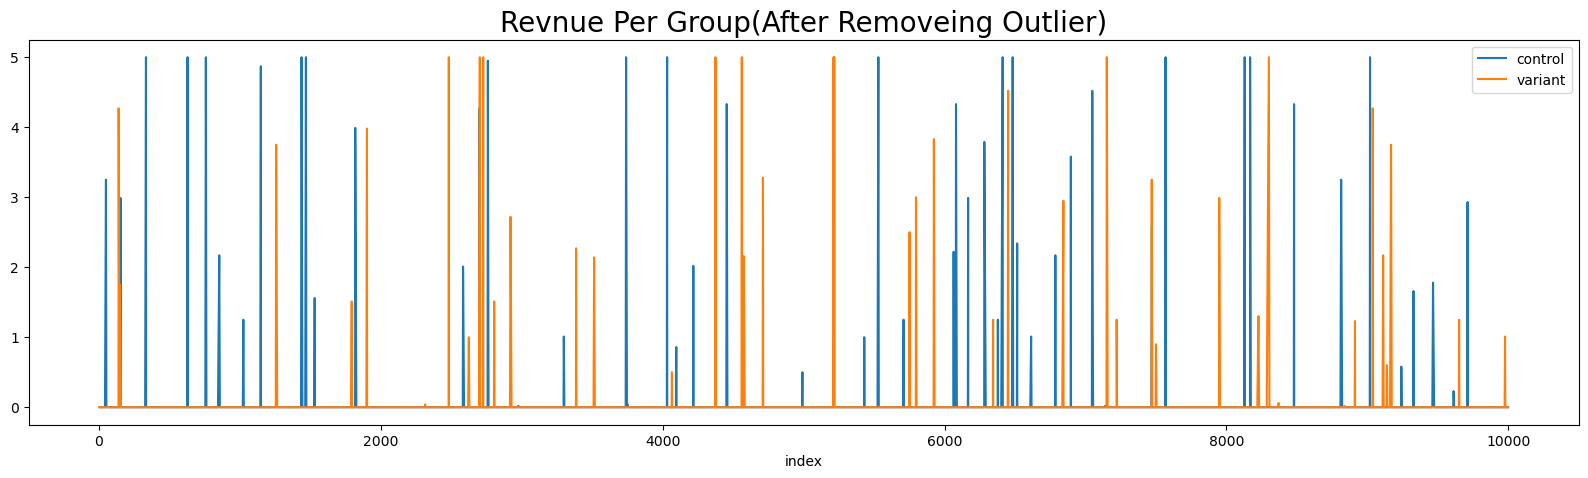

In [15]:
df[df['VARIANT_NAME'] == "control"].reset_index().set_index("index")['REVENUE'].plot(legend = True, label = "control", figsize = (20,5))
df[df['VARIANT_NAME'] == "variant"].reset_index().set_index("index")['REVENUE'].plot(legend = True, label = "variant")
plt.title('revnue per group(after removeing outlier)'.title(),fontsize = 20)

In [16]:
sms.DescrStatsW(df["REVENUE"]).tconfint_mean()

(0.03595388879674289, 0.05730476029716155)

See if there is any diffrent between *control* and *variant* in Revenue

In [17]:
tot_revenue=df['REVENUE'].sum()
REVENUE=df.groupby('VARIANT_NAME').agg({'REVENUE': ['sum', 'count']}).reset_index()
REVENUE['REVENUE prec']=REVENUE['REVENUE']['sum']/tot_revenue*100
REVENUE

VARIANT_NAME   REVENUE       REVENUE prec
                     sum count             
0      control 165.06000  3026     58.31685
1      variant 117.98000  3044     41.68315

the *control* verison is acuaualy giveing more revenue than the *variant* by around 16%

Lets run the A/B to be more sure 

# A/B Testing 
## steps:
* Check normality
* If Normal Distribution, check homogeneity
* Split & Define Control Group & Test Group
* Apply Shapiro Test for normality
* If parametric apply Levene Test for homogeneity of variances
* If Parametric + homogeneity of variances apply T-Test
* If Parametric - homogeneity of variances apply Welch Test
* If Non-parametric apply Mann Whitney U Test directly

## Check Normality

In [29]:
from scipy.stats import shapiro
groupA = df[df['VARIANT_NAME'] == 'control']['REVENUE']
groupB = df[df['VARIANT_NAME'] == 'variant']['REVENUE']
Distribution=('Normal Distribution' if shapiro(groupA)[1] < 0.05 == False and shapiro(groupB)[1] == False else 'Not Normal')
print(Distribution)

Not Normal


In [48]:
groupA.head()

7    0.00000
9    0.00000
10   0.00000
11   0.00000
12   0.00000
Name: REVENUE, dtype: float64

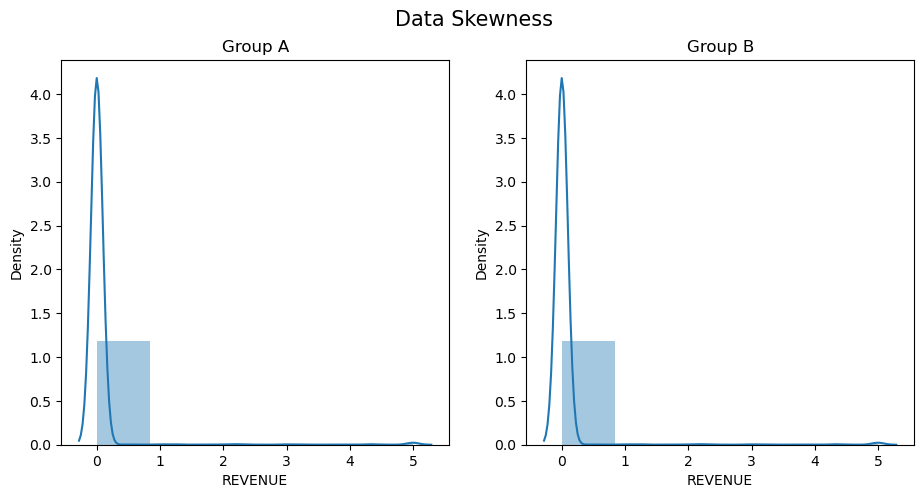

In [62]:
plt.figure(figsize=(11,5))
plt.subplot(1, 2, 1)
sns.distplot(groupA, bins=6)
plt.title('group A'.title())
plt.subplot(1, 2, 2)
sns.distplot(groupA, bins=6)
plt.title('group B'.title())
plt.suptitle('Data skewness'.title(),fontsize=15)
plt.show()

Both Distributions is not normal (Postive or right Skewed)

### Apply Mann Whitney U Test directly

In [63]:
import scipy.stats as stats
ttest = stats.mannwhitneyu(groupA, groupB)[1]
# H0: M1 == M2 - False
# H1: M1 != M2 - True
temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
temp["Test Type"]=("Non-Parametric" if Distribution=='Not Normal' else 'Parametric')
temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]
print(temp)

        Test Type      AB Hypothesis  p-value                  Comment
0  Non-Parametric  Fail to Reject H0  0.24485  A/B groups are similar!


### Here we observe that there is no statistical difference on the revenues of the control and variant variables.Since p value is greater than 0.05
### -> H0 HYPOTESIS IS NOT REJECTED!